$\mathcal{D} = {(\mathbf{k}_1, \mathbf{v}_1),...,(\mathbf{k}_m, \mathbf{v}_m)}$ is the database of key-value pairs, $\mathbf{q}$ is the query:

$
\text{Attention}(\mathbf{q}, \mathcal{D}) 
\overset{\text{def}}{=} 
\sum_{i=1}^{m} \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i,
$

$\alpha(\mathbf{q}, \mathbf{k}_i)$ is the attention weight (usually computed via a similarity or alignment function).

You can pick any function $a(\mathbf{q}, \mathbf{k})$ and then defines the attention weight as a softmax-normalized similarity between the query and key:
$
\alpha(\mathbf{q}, \mathbf{k}_i) = 
\frac{\exp(a(\mathbf{q}, \mathbf{k}_i))}{
\sum_{j} \exp(a(\mathbf{q}, \mathbf{k}_j))}.
$


![attention polling](./Images/attentionPolling.png)

In [2]:
import torch
from d2l import torch as d2l

In [3]:
#@save
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),cmap='Reds'):
    """Show heatmaps of matrices."""
    d2l.use_svg_display()
    num_rows, num_cols, _, _ = matrices.shape
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize, sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

In [4]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
attention_weights

tensor([[[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]]])

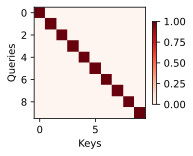

In [5]:
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

=============================================Attention Pooling by Similarity===========================================

In [6]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

d2l.use_svg_display()

similarity kernels from the kernel smoothing / density estimation family

1. **Gaussian kernel**
$
\alpha(\mathbf{q}, \mathbf{k}) = \exp\left(-\frac{1}{2} \|\mathbf{q} - \mathbf{k}\|^2 \right)
$

2. **Boxcar (Uniform) kernel**
$
\alpha(\mathbf{q}, \mathbf{k}) =
\begin{cases}
1, & \text{if } \|\mathbf{q} - \mathbf{k}\| \le 1 \\
0, & \text{otherwise}
\end{cases}
$

3. **Epanechnikov kernel**
$
\alpha(\mathbf{q}, \mathbf{k}) = \max(0, 1 - \|\mathbf{q} - \mathbf{k}\|)
$

All the kernels  defined in this section are translation and rotation invariant; that is, if we shift and rotate $\mathbf{k}$ and $\mathbf{q}$ in the same manner, the value of $\alpha(\mathbf{q}, \mathbf{k})$ remains unchanged. For simplicity we thus pick scalar arguments $\mathbf{k}, \mathbf{q} \in \mathbb{R}^d$ and pick the key $\mathbf{k}$ = 0 as the origin. This yields:


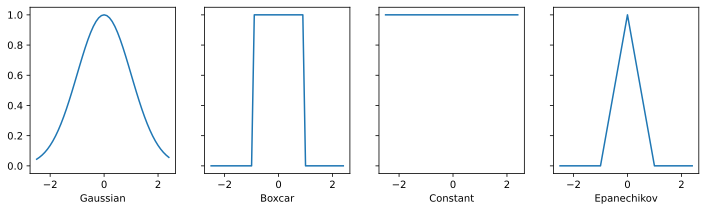

In [7]:

# Define some kernels
def gaussian(x):
    return torch.exp(-x**2 / 2)

def boxcar(x):
    return torch.abs(x) < 1.0

def constant(x):
    return 1.0 + 0 * x

def epanechikov(x):
    return torch.max(1 - torch.abs(x), torch.zeros_like(x))

fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))

kernels = (gaussian, boxcar, constant, epanechikov)
names = ('Gaussian', 'Boxcar', 'Constant', 'Epanechikov')
x = torch.arange(-2.5, 2.5, 0.1)
for kernel, name, ax in zip(kernels, names, axes):
    ax.plot(x.detach().numpy(), kernel(x).detach().numpy())
    ax.set_xlabel(name)

d2l.plt.show()

In [8]:
def f(x):
    return 2 * torch.sin(x) + x

n = 40
# torch.rand generates uniform random numbers in [0, 1)
# torch.randn generates standard normal random numbers with mean 0 and variance 1
x_train, _ = torch.sort(torch.rand(n) * 5)
y_train = f(x_train) + torch.randn(n)
x_val = torch.arange(0, 5, 0.1)
y_val = f(x_val)

x_train, y_train, x_train.shape, y_train.shape, x_val.shape, y_val.shape

(tensor([0.1061, 0.1710, 0.2277, 0.4652, 0.5606, 0.9380, 0.9887, 1.0153, 1.1411,
         1.3448, 1.6719, 1.7179, 1.8441, 1.8499, 1.8607, 1.9696, 2.1293, 2.1655,
         2.2400, 2.3792, 2.4257, 2.5821, 2.6322, 2.6982, 2.7582, 2.9593, 3.0002,
         3.1285, 3.2966, 3.3468, 3.6348, 3.6558, 3.8352, 3.8548, 3.9016, 4.0236,
         4.0860, 4.2129, 4.5551, 4.8077]),
 tensor([-0.1819,  0.5877,  1.3581,  0.7468,  1.5795,  0.4443,  3.1291,  1.3484,
          2.0771,  4.0835,  4.1115,  4.6177,  3.7115,  3.9810,  3.4221,  2.4532,
          4.3833,  3.8784,  2.5143,  4.6744,  5.1867,  3.0403,  4.1485,  3.0909,
          3.3728,  3.5314,  4.4171,  2.6106,  1.7996,  3.2804,  4.6087,  0.3975,
          2.6970,  2.0885,  3.0787,  4.1711,  1.8206,  1.9629,  2.0635,  2.4531]),
 torch.Size([40]),
 torch.Size([40]),
 torch.Size([50]),
 torch.Size([50]))

 Attention Pooling via Nadaraya–Watson Regression

In [9]:
#  each validation feature be a query
#  each training feature–label pair be a key–value pair.
def nadaraya_watson(x_train, y_train, x_val, kernel):

    # x_train: (num_train, ), y_train: (num_train, )
    # x_train.reshape((-1, 1)): (num_train, 1)
    # x_val.reshape((1, -1)): (1, num_val)
    # dists.shape: (num_train, num_val)

	# •	x_train: training inputs → keys
	# •	y_train: training labels → values
	# •	x_val: validation inputs → queries
	# •	kernel: function measuring similarity (e.g., Gaussian)

    # Conceptually:
	# •	Compare every training point with every query point
	# •	Result: a matrix of distances
    # Interpretation: How far is each key from each query?
    dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))

    # Each column/row corresponds to each query/key
    # k.shape: (num_train, num_val)
    # Convert distances into similarities (kernel)
    #   Nearby points → large values
	#   Faraway points → small values
    # Interpretation：How much attention should each key get for each query?
    # This is unnormalized attention.
    k = kernel(dists).type(torch.float32)

    # Normalization over keys for each query
    # Normalize over training points， Done separately for each query
    # Interpretation:
    #     For a fixed query, attention weights across all keys sum to 1.
    #     This is exactly soft attention, just without softmax.
    attention_w = k / k.sum(0)

    # Conceptually: Each query prediction = sum(attention × training label)
    # Interpretation: Predict by averaging labels of nearby points, weighted by similarity.
    y_hat = y_train@attention_w # (num_train) @ (num_train, num_val) = (num_val)
    return y_hat, attention_w

Above function implements Nadaraya–Watson kernel regression, which is:

Predict a value at a query point by taking a **weighted average of nearby training labels**, where “nearby” is defined by a kernel.

In modern ML language:

	• Each validation point = a query
	• Each training point = a key–value pair
	• Kernel = attention score
	• Normalized kernel weights = attention weights

So this is literally attention without learnable parameters.

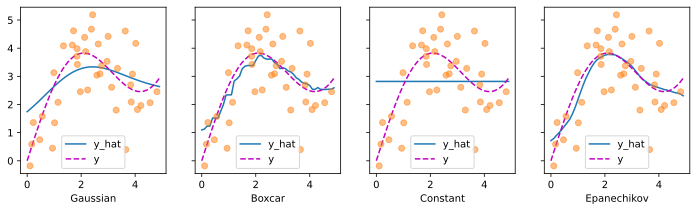

In [10]:
def plot(x_train, y_train, x_val, y_val, kernels, names, attention=False):
    fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))
    for kernel, name, ax in zip(kernels, names, axes):
        y_hat, attention_w = nadaraya_watson(x_train, y_train, x_val, kernel)
        if attention:
            pcm = ax.imshow(attention_w.detach().numpy(), cmap='Reds')
        else:
            ax.plot(x_val, y_hat)
            ax.plot(x_val, y_val, 'm--')
            ax.plot(x_train, y_train, 'o', alpha=0.5);
        ax.set_xlabel(name)
        if not attention:
            ax.legend(['y_hat', 'y'])
    if attention:
        fig.colorbar(pcm, ax=axes, shrink=0.7)

plot(x_train, y_train, x_val, y_val, kernels, names)

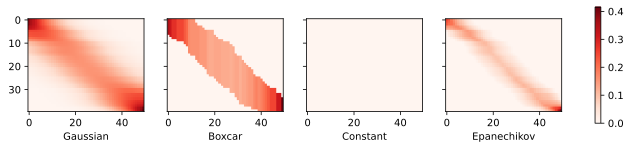

In [11]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

===============================================Attention Scoring Functions==============================================

![attention polling with softmax](./Images/attentionPollingSoftmax.png)

In [12]:
import math
import torch
from torch import nn
from d2l import torch as d2l

Scaled dot product attention scoring function

$$
a(\mathbf{q}, \mathbf{k}_i) = \frac{\mathbf{q}^\top \mathbf{k}_i}{\sqrt{d}}.
$$

$$
\alpha(\mathbf{q}, \mathbf{k}_i) = \text{softmax}(a(\mathbf{q}, \mathbf{k}_i))
= \frac{\exp\left(\frac{\mathbf{q}^\top \mathbf{k}_i}{\sqrt{d}}\right)}
{\sum_{j=1}^{n} \exp\left(\frac{\mathbf{q}^\top \mathbf{k}_j}{\sqrt{d}}\right)}.
$$


#### Insert a new dimension into tensor
None (or np.newaxis) inserts a new dimension exactly at the position where it appears in the indexing expression.

Think of indexing as building a shape template from left to right.

	• Every: keeps an existing dimension
	• Every None adds a dimension of size 1
	• The position of None = position of the new axis

1️⃣ 1D tensor examples (x.shape == (5,))
| Expression              | Result shape | Meaning |
|-------------------------|--------------|--------|
| `x[:]`                  | `(5,)`       | unchanged |
| `x[None]`               | `(1, 5)`     | add axis at front |
| `x[:, None]`            | `(5, 1)`     | add axis at end |
| `x[None, :]`            | `(1, 5)`     | same as `x[None]` |
| `x[:, None, None]`      | `(5, 1, 1)`  | add two axes |

2️⃣ 2D tensor examples (X.shape == (batch, features))
| Expression        | Result shape |
|------------------|--------------|
| `X[:, :]`         | `(batch, features)` |
| `X[:, None, :]`   | `(batch, 1, features)` |
| `X[None, :, :]`   | `(1, batch, features)` |
| `X[:, :, None]`   | `(batch, features, 1)` |

In [13]:
# Masked softmax operation.

from operator import add

# batch_size = how many sequences
# num_queries = how many attention questions per sequence
# num_keys = how many positions can be attended to
# valid_len = how many of those positions are real (not padding)

def masked_softmax(X, valid_lens):  #@save
    """Perform softmax operation by masking elements on the last axis."""
    # X shape: (batch_size × num_queries, num_keys)
    # valid_lens
	# •	Tells us how many keys are valid for each query
	# •	Shape: (batch_size × num_queries, )
    def _sequence_mask(X, valid_len, value=0):
        print("valid_len:", valid_len)

        maxlen = X.size(1) # = num_keys

        # (1, num_keys) < (batch_size × num_queries, 1)
        # Apply broadcast, mask shape (batch_size × num_queries, num_keys)

        # left is something like: tensor([[0., 1., 2., 3., 4., 5., .. (maxlen-1)]]) 
        # These numbers answer the question: What position is this element in the sequence?
        # This asks, for every row i and column j: Is j < valid_len[i] ?

        # Concrete numeric example:
        # batch_size = 3, num_queries = 1, num_keys = 6
        # X shape (3, 6) (originally (3, 1, 6))
        # maxlen = num_keys = 6
        # valid_len = tensor([2, 4, 5]) meaning:
        #   sequence 0 has 2 valid keys
        #   sequence 1 has 4 valid keys
	    #   sequence 2 has 5 valid keys

        # Step 1: column indices
        #   torch.arange(maxlen)[None, :] → [[0, 1, 2, 3, 4, 5]]
        # Step 2: row lengths
        #   valid_len[:, None] → [[2], [4], [5]]
        # Step 3: comparison
        #   [[0, 1, 2, 3, 4, 5]] < [[2], [4], [5]]
        # Broadcast:
            # [[0, 1, 2, 3, 4, 5],
            #  [0, 1, 2, 3, 4, 5],
            #  [0, 1, 2, 3, 4, 5]]
            #         <
            # [[2, 2, 2, 2, 2, 2],
            #  [4, 4, 4, 4, 4, 4],
            #  [5, 5, 5, 5, 5, 5]]
        # Result:
        # [[ True,  True, False, False, False, False],
        # [ True,  True,  True,  True, False, False],
        # [ True,  True,  True,  True,  True, False]]

        mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        # X shape: (batch_size, num_queries, num_keys)
        shape = X.shape
        if valid_lens.dim() == 1:
            # Repeat the first dimension of valid_lens by shape[1](num_queries) times
            # valid_lens shape will be (batch_size × num_queries,)
            valid_lens = torch.repeat_interleave(input = valid_lens, repeats = shape[1])
        else:
            # valid_lens shape will be (batch_size × num_queries,)
            valid_lens = valid_lens.reshape(-1) # flatten into 1D
    
        # On the last axis, replace masked elements with a very large negative value, whose exponentiation outputs 0
        # X.reshape(-1, shape[-1]): (batch_size × num_queries, num_keys)
        # Each row = one query’s attention scores over all keys.
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6) 

        # X will be reshaped back into 3D and then apply softmax for last dimension
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [40]:
orig_x = torch.rand(2, 2, 4)
print("Original X: ", orig_x)
x = masked_softmax(orig_x.clone(), torch.tensor([2, 3]))
print("Final X: ", x)

Original X:  tensor([[[0.9222, 0.2128, 0.7089, 0.0355],
         [0.8411, 0.2481, 0.9271, 0.1599]],

        [[0.2095, 0.8603, 0.0402, 0.6621],
         [0.4385, 0.6203, 0.4326, 0.9751]]])
valid_len: tensor([2, 2, 3, 3])
Final X:  tensor([[[0.6703, 0.3297, 0.0000, 0.0000],
         [0.6441, 0.3559, 0.0000, 0.0000]],

        [[0.2659, 0.5097, 0.2245, 0.0000],
         [0.3131, 0.3756, 0.3113, 0.0000]]])


In [42]:
# If we need more fine-grained control to specify the valid length for each of the two vectors of 
# every example, we simply use a two-dimensional tensor of valid lengths. 

print("Original X: ", orig_x)
x2 = masked_softmax(orig_x.clone(), torch.tensor([[1, 3], [2, 4]]))
print("Final X: ", x2)

Original X:  tensor([[[0.9222, 0.2128, 0.7089, 0.0355],
         [0.8411, 0.2481, 0.9271, 0.1599]],

        [[0.2095, 0.8603, 0.0402, 0.6621],
         [0.4385, 0.6203, 0.4326, 0.9751]]])
valid_len: tensor([1, 3, 2, 4])
Final X:  tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3784, 0.2091, 0.4124, 0.0000]],

        [[0.3428, 0.6572, 0.0000, 0.0000],
         [0.2039, 0.2446, 0.2027, 0.3488]]])


In [43]:
print("Original X: ", orig_x)
x3 = masked_softmax(orig_x.clone(), None)
print("Final X: ", x3)

Original X:  tensor([[[0.9222, 0.2128, 0.7089, 0.0355],
         [0.8411, 0.2481, 0.9271, 0.1599]],

        [[0.2095, 0.8603, 0.0402, 0.6621],
         [0.4385, 0.6203, 0.4326, 0.9751]]])
Final X:  tensor([[[0.3688, 0.1814, 0.2979, 0.1519],
         [0.3176, 0.1755, 0.3461, 0.1607]],

        [[0.1875, 0.3594, 0.1583, 0.2948],
         [0.2039, 0.2446, 0.2027, 0.3488]]])


Batch Matrix Multiplication

Another commonly used operation is to multiply batches of matrices by one another. This comes in handy when we have minibatches of queries, keys, and values.
More specifically, assume that

$
\mathbf{Q} = [\mathbf{Q}_1, \mathbf{Q}_2, \ldots, \mathbf{Q}_n] \in \mathbb{R}^{n \times a \times b},
\quad
\mathbf{K} = [\mathbf{K}_1, \mathbf{K}_2, \ldots, \mathbf{K}_n] \in \mathbb{R}^{n \times b \times c}.
$

$
\mathrm{BMM}(\mathbf{Q}, \mathbf{K}) = [\mathbf{Q}_1 \mathbf{K}_1, \mathbf{Q}_2 \mathbf{K}_2, \ldots, \mathbf{Q}_n \mathbf{K}_n]
\in \mathbb{R}^{n \times a \times c}.
$


In [17]:
Q = torch.ones((2, 3, 4))
K = torch.ones((2, 4, 6))
d2l.check_shape(torch.bmm(Q, K), (2, 3, 6))

Scaled Dot Product Attention

The scaled dot-product attention of queries
$\mathbf{Q} \in \mathbb{R}^{n \times d}$, keys $\mathbf{K} \in \mathbb{R}^{m \times d}$, and values $\mathbf{V} \in \mathbb{R}^{m \times v}$ can be written as
$\text{softmax}\left( \frac{\mathbf{Q}\mathbf{K}^\top}{\sqrt{d}} \right) \mathbf{V} \in \mathbb{R}^{n \times v}$


In [ ]:
class DotProductAttention(nn.Module):  #@save
    """
    Scaled Dot-Product Attention.

    For each query vector:
      1. Compute dot-product similarity with all key vectors
      2. Scale by sqrt(d) to stabilize gradients
      3. Mask out invalid (padding) keys
      4. Apply softmax to get attention weights
      5. Return weighted sum of value vectors
    """

    def __init__(self, dropout):
        super().__init__()
        # Dropout applied to attention weights (not to values directly)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens=None):
        """
        Parameters
        ----------
        queries : Tensor
            Shape: (batch_size, num_queries, query_dim)
            One query vector per position that wants to attend to keys.

        keys : Tensor
            Shape: (batch_size, num_keys, key_dim)
            Key vectors that queries are compared against.
            NOTE: query_dim MUST equal key_dim.

        values : Tensor
            Shape: (batch_size, num_keys, value_dim)
            Value vectors to be averaged using attention weights.
            value_dim does NOT have to equal d.

        valid_lens : Tensor or None
            Shape: (batch_size,) or (batch_size, num_queries)
            For each sequence (or each query), specifies how many key
            positions are valid (non-padding). Keys beyond this length
            are masked out before softmax.

        Returns
        -------
        output : Tensor
            Shape: (batch_size, num_queries, value_dim)
            Attention-weighted sum of values for each query.
        """

        # Dimensionality of query/key vectors
        d = queries.shape[-1]

        # Compute raw attention scores using batched matrix multiplication
        #
        # queries: (batch_size, num_queries, d)
        # keys.T:  (batch_size, d, num_keys)
        #
        # Result:
        # scores: (batch_size, num_queries, num_keys)
        #
        # Each score[b, q, k] = dot(query[b, q], key[b, k])
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)

        # Apply masked softmax:
        #  - mask out padding keys using valid_lens
        #  - softmax along the key dimension
        #
        # attention_weights shape:
        # (batch_size, num_queries, num_keys)
        self.attention_weights = masked_softmax(scores, valid_lens)

        # Weighted sum of value vectors
        #
        # attention_weights: (batch_size, num_queries, num_keys)
        # values:            (batch_size, num_keys, value_dim)
        #
        # Result:
        # output: (batch_size, num_queries, value_dim)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [19]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DotProductAttention(dropout=0.5)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

valid_len: tensor([2, 6])


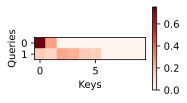

In [20]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)), xlabel='Keys', ylabel='Queries')

When queries $\mathbf{q}$ and keys $\mathbf{k}$ are vectors of different dimension, we can either use a matrix to address the mismatch via $\mathbf{q}^\top\mathbf{M}\mathbf{k}$,
 or we can use additive attention as the scoring function, Another benefit is that, as its name indicates, the attention is additive. This can lead to some minor computational savings. Given a query $\mathbf{q} \in \mathbb{R}^{q}$ and a key $\mathbf{k} \in \mathbb{R}^{k}$  the additive attention scoring function is given by:

$
a(\mathbf{q}, \mathbf{k}) = \mathbf{w}_v^\top 
\tanh\left( \mathbf{W}_q \mathbf{q} + \mathbf{W}_k \mathbf{k} \right)
\in \mathbb{R},
$
where $\mathbf{W}_q \in \mathbb{R}^{h \times q}$, $\mathbf{W}_k \in \mathbb{R}^{h \times k}$, and $\mathbf{w}_v \in \mathbb{R}^{h}$ are learnable parameters.




In [ ]:
class AdditiveAttention(nn.Module):  #@save
    """
    Additive (Bahdanau) Attention.

    For each (query, key) pair:
      1. Project query and key into a shared hidden space
      2. Combine them with addition
      3. Apply tanh nonlinearity
      4. Reduce to a scalar score
      5. Mask invalid keys and apply softmax
      6. Return weighted sum of values
    """

    def __init__(self, num_hiddens, dropout, **kwargs):
        super().__init__(**kwargs)

        # Linear projections to a shared hidden space
        # LazyLinear infers input dimension at first use
        self.W_q = nn.LazyLinear(out_features=num_hiddens, bias=False)
        self.W_k = nn.LazyLinear(out_features=num_hiddens, bias=False)

        # Projects combined (query + key) features to a scalar score
        self.w_v = nn.LazyLinear(out_features=1, bias=False)

        # Dropout applied to attention weights
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        """
        Parameters
        ----------
        queries : Tensor
            Shape: (batch_size, num_queries, query_dim)
            Query vectors representing positions that want to attend.

        keys : Tensor
            Shape: (batch_size, num_keys, key_dim)
            Key vectors representing positions that can be attended to.

        values : Tensor
            Shape: (batch_size, num_keys, value_dim)
            Value vectors that will be averaged using attention weights.

        valid_lens : Tensor
            Shape: (batch_size,) or (batch_size, num_queries)
            Number of valid (non-padding) keys for each sequence or query.

        Returns
        -------
        output : Tensor
            Shape: (batch_size, num_queries, value_dim)
            Attention-weighted sum of values.
        """

        # Project queries and keys into the same hidden dimension
        #
        # queries: (batch_size, num_queries, num_hiddens)
        # keys:    (batch_size, num_keys,    num_hiddens)
        queries = self.W_q(queries)
        keys = self.W_k(keys)

        # Prepare for broadcasting to compute all (query, key) pairs
        #
        # queries.unsqueeze(2):
        #   (batch_size, num_queries, 1,        num_hiddens)
        # keys.unsqueeze(1):
        #   (batch_size, 1,           num_keys, num_hiddens)
        #
        # The singleton dimensions (1) allow broadcasting so that:
        #   each query is combined with every key
        features = queries.unsqueeze(2) + keys.unsqueeze(1)

        # features shape after broadcasting:
        # (batch_size, num_queries, num_keys, num_hiddens)
        features = torch.tanh(features)

        # Project combined features to scalar attention scores
        #
        # self.w_v(features):
        #   (batch_size, num_queries, num_keys, 1)
        #
        # squeeze removes the last dimension
        scores = self.w_v(features).squeeze(-1)

        # scores shape:
        # (batch_size, num_queries, num_keys)

        # Apply masked softmax over the key dimension
        # Masked positions (padding keys) receive zero probability
        self.attention_weights = masked_softmax(scores, valid_lens)

        # Compute weighted sum of value vectors
        #
        # attention_weights: (batch_size, num_queries, num_keys)
        # values:            (batch_size, num_keys,    value_dim)
        #
        # output:
        # (batch_size, num_queries, value_dim)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [22]:
queries = torch.normal(0, 1, (2, 1, 20))

attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

valid_len: tensor([2, 6])


/workspaces/pytorch-basics/.venv310/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


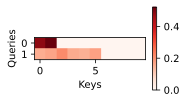

In [23]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)), xlabel='Keys', ylabel='Queries')

In this section we introduced the two key attention scoring functions: dot product and additive attention. They are effective tools for aggregating across sequences of variable length. In particular, the dot product attention is the mainstay of modern Transformer architectures. When queries and keys are vectors of different lengths, we can use the additive attention scoring function instead. Optimizing these layers is one of the key areas of advance in recent years.

=======================The Bahdanau Attention Mechanism=========================

Conventionally, in an RNN all relevant information about a source sequence is translated into some internal fixed-dimensional state representation by the encoder. It is this very state that is used by the decoder as the complete and exclusive source of information for generating the translated sequence. In other words, the sequence-to-sequence mechanism treats the intermediate state as a sufficient statistic of whatever string might have served as input.

![statePassedfromEncoderToDecoder](./Images/statePassedfromEncoderToDecoder.png)

While this is quite reasonable for short sequences, it is clear that it is infeasible for long ones, such as a book chapter or even just a very long sentence. After all, before too long there will simply not be enough “space” in the intermediate representation to store all that is important in the source sequence. Consequently the decoder will fail to translate long and complex sentences

Bahdanau et al. (2014) proposed a differentiable attention model without the unidirectional alignment limitation.
**When predicting a token, if not all the input tokens are relevant, the model aligns (or attends) only to parts of the input sequence that are deemed relevant to the current prediction.** This is then used to update the current state before generating the next token. While quite innocuous in its description, this Bahdanau attention mechanism has arguably turned into one of the most influential ideas of the past decade in deep learning, giving rise to Transformers (Vaswani et al., 2017) and many related new architectures.

![BahdanauAttention](./Images/BahdanauAttention.png)

In [24]:
import torch
from torch import nn
from d2l import torch as d2l

##### Explanation of `x[-1]`, `x[:, -1]`, and `x[:, :, -1]`

| Indexing        | 2D Tensor `(3, 4)`                         | 3D Tensor `(3, 2, 4)`                                  | Equivalent Full Slice (Mental Model) |
|-----------------|---------------------------------------------|----------------------------------------------------------|--------------------------------------|
| `x[-1]`         | Last row → shape `(4,)`                    | Last slice → shape `(2, 4)` (last batch)                | `x[-1, :, :, ..., :]`                |
| `x[:, -1]`      | Last column → shape `(3,)`                 | Last row per slice → shape `(3, 4)`                     | `x[:, -1, :, ..., :]`                |
| `x[:, :, -1]`   | ❌ Not applicable (only 2 dims)            | Last column per slice → shape `(3, 2)`                  | `x[:, :, -1, ..., :]`                |

##### 🧠 Mental model (one-line rule)

> **If fewer indices are given than dimensions, Python automatically fills the remaining dimensions with `:` from left to right.**  
>  
> `x[i]  ≡  x[i, :, :, ..., :]` where the number of `:` is `x.ndim - 1`.

##### Why this matters in ML code
- `x[-1]` → **last batch**
- `x[:, -1]` → **last timestep / token**
- `x[:, :, -1]` → **last feature**

This way of thinking scales cleanly to **4D / 5D tensors** (attention, CNNs, transformers) without guesswork.


In [26]:
class AttentionDecoder(d2l.Decoder):  #@save
    """The base attention-based decoder interface."""
    def __init__(self):
        super().__init__()

    @property
    def attention_weights(self):
        raise NotImplementedError

In [ ]:
# This is a GRU-based seq2seq decoder with additive attention:
# At each decoding step:
# 	1.	Take the last-layer decoder hidden state as the query
# 	2.	Attend over all encoder hidden states (keys = values)
# 	3.	Concatenate context vector + current input embedding
# 	4.	Feed into GRU to get the next hidden state
# 	5.	Project to vocabulary logits

class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super().__init__()
        self.attention = d2l.AdditiveAttention(num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(d2l.init_seq2seq)

    def init_state(self, enc_outputs, enc_valid_lens):
        # outputs:      (num_steps, batch_size, num_hiddens)
        # hidden_state: (num_layers, batch_size, num_hiddens)
        outputs, hidden_state = enc_outputs
        # After permute:
        # enc_coutputs: (batch_size, num_steps, num_hiddens) This tensor will be used
        # as both keys and values
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # Shape of enc_outputs:  (batch_size, num_steps, num_hiddens)
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        # Shape of enc_valid_lens: (batch_size,)
        enc_outputs, hidden_state, enc_valid_lens = state

        # Input X:  (batch_size, num_steps)
        # self.embedding(X): (batch_size, num_steps, embed_size)
        # output X: (num_steps, batch_size, embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []

        # We now iterate one decoding step at a time
        for x in X:
            # hidden_state[-1]: (batch_size, num_hiddens) last layer's hidden state
            # The hidden states of the last layer of the encoder at all time steps, used as keys and values for attention;
            # This is the decoder’s current semantic state, so it’s the right thing to use as the attention query.
            # query: (batch_size, 1, num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)

            # Here:
            #     • query = decoder state (what we’re looking for)
            #     • keys = encoder hidden states
            #     • values = encoder hidden states
            # In seq2seq attention:
            #     • Encoder hidden states already encode meaning
            #     • We score how relevant each encoder state is
            #     • Then take a weighted sum of those same states
            # so keys == values == encoder outputs
            # This is standard Bahdanau / additive attention.

            # context: (batch_size, 1, num_hiddens)
            context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)

            # Concatenate on the feature dimension
	        # • x (embedding): (batch_size, 1, embed_size)
	        # • Concatenated x: (batch_size, 1, embed_size + num_hiddens)
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)

            # •	Input to GRU: (1, batch_size, embed_size + num_hiddens)
            # •	Output out:   (1, batch_size, num_hiddens)
            # •	Updated hidden_state: (num_layers, batch_size, num_hiddens)        
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)

        # • Before dense: (num_steps, batch_size, num_hiddens)
	    # • After dense: (num_steps, batch_size, vocab_size)
	    # • Returned as: (batch_size, num_steps, vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

In [ ]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 7
encoder = d2l.Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
decoder = Seq2SeqAttentionDecoder(vocab_size, embed_size, num_hiddens, num_layers)
X = torch.zeros((batch_size, num_steps), dtype=torch.long)

state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
d2l.check_shape(output, (batch_size, num_steps, vocab_size))
d2l.check_shape(state[0], (batch_size, num_steps, num_hiddens))
d2l.check_shape(state[1][0], (batch_size, num_hiddens))

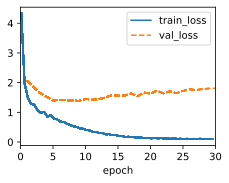

In [29]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = d2l.Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [ ]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['<unk>', 'tard', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


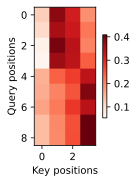

In [31]:
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), d2l.try_gpu(), data.num_steps, True)
attention_weights = torch.cat(
    [step[0][0][0] for step in dec_attention_weights], 0)
attention_weights = attention_weights.reshape((1, 1, -1, data.num_steps))

# Plus one to include the end-of-sequence token
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')

============================================ Multi-Head Attention ==========================================

Instead of one attention view, multi-head attention gives the model multiple attention “perspectives” at the same time, then blends them.

![Multi-head attention.png](./Images/Multi-head%20attention.png)

In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

##### Multi-Head Attention: Mathematical Formulation

Multi-head attention allows a model to attend to information from **multiple representation subspaces** simultaneously by applying the same attention mechanism in parallel with different learned linear projections.

##### Per-Head Attention Computation

Given:
- Query vector: $\mathbf{q} \in \mathbb{R}^{d_q}$
- Key vector: $\mathbf{k} \in \mathbb{R}^{d_k}$
- Value vector: $\mathbf{v} \in \mathbb{R}^{d_v}$

Each attention head $h_i$ for $i = 1, \dots, h$ is computed as:

$$
\mathbf{h}_i
=
f\!\left(
\mathbf{W}_i^{(q)} \mathbf{q},
\mathbf{W}_i^{(k)} \mathbf{k},
\mathbf{W}_i^{(v)} \mathbf{v}
\right)
\in \mathbb{R}^{p_v}
$$

where:
- $\mathbf{W}_i^{(q)} \in \mathbb{R}^{p_q \times d_q}$
- $\mathbf{W}_i^{(k)} \in \mathbb{R}^{p_k \times d_k}$
- $\mathbf{W}_i^{(v)} \in \mathbb{R}^{p_v \times d_v}$

are **learnable linear projection matrices**, and $f(\cdot)$ is an **attention pooling function**, such as:
- additive attention, or  
- scaled dot-product attention.

##### Multi-Head Output Projection

The outputs of all $h$ attention heads are **concatenated** and passed through a final linear transformation:

$$
\mathbf{o}
=
\mathbf{W}_o
\begin{bmatrix}
\mathbf{h}_1 \\
\vdots \\
\mathbf{h}_h
\end{bmatrix}
\in \mathbb{R}^{p_o}
$$

where:
- $\mathbf{W}_o \in \mathbb{R}^{p_o \times (h \cdot p_v)}$ is a learnable output projection matrix.

##### Key Insight

Each attention head can focus on **different parts or dependency patterns** of the input (e.g., short-range vs. long-range relationships). By combining multiple heads, multi-head attention can express **richer and more sophisticated interactions** than a single attention mechanism.

In [ ]:
class MultiHeadAttention(d2l.Module):  #@save
    """Multi-head dot-product attention."""
    def __init__(self, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__()
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)

        # Linear projections for queries, keys, values, and final output
        self.W_q = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_k = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_v = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_o = nn.LazyLinear(num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        """
        queries: (batch_size, num_queries, num_hiddens)
        keys:    (batch_size, num_keys, num_hiddens)
        values:  (batch_size, num_keys, num_hiddens)
        valid_lens: (batch_size,) or (batch_size, num_queries)
        """

        # Project and split into multiple heads
        # queries: (batch_size * num_heads, num_queries, num_hiddens / num_heads)
        # keys:    (batch_size * num_heads, num_keys,    num_hiddens / num_heads)
        # values:  (batch_size * num_heads, num_keys,    num_hiddens / num_heads)
        queries = self.transpose_qkv(self.W_q(queries))
        keys    = self.transpose_qkv(self.W_k(keys))
        values  = self.transpose_qkv(self.W_v(values))

        if valid_lens is not None:
            # Repeat valid lengths once per head to match expanded batch size
            # Inut valid_lens:   (batch_size,) or (batch_size, num_queries)
            # Output valid_lens: (batch_size * num_heads,) or (batch_size * num_heads, num_queries) 
            valid_lens = torch.repeat_interleave(valid_lens, repeats=self.num_heads, dim=0)

        # Apply scaled dot-product attention per head
        # Output: (batch_size * num_heads, num_queries, num_hiddens / num_heads)
        output = self.attention(queries, keys, values, valid_lens)

        # Merge all heads back together
        # output_concat: (batch_size, num_queries, num_hiddens)
        output_concat = self.transpose_output(output)

        # Final linear projection
        return self.W_o(output_concat)

In [ ]:
@d2l.add_to_class(MultiHeadAttention)  #@save
def transpose_qkv(self, X):
    """Transposition for parallel computation of multiple attention heads."""
    # Input X:  (batch_size, num_queries or num_keys, num_hiddens)
    # Output X: (batch_size, num_queries or num_keys, num_heads, num_hiddens / num_heads)
    X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)

    # Output X: (batch_size, num_heads, num_queries or num_keys, num_hiddens / num_heads)
    X = X.permute(0, 2, 1, 3)
    
    # Output: (batch_size * num_heads, num_queries or num_keys, num_hiddens / num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])

@d2l.add_to_class(MultiHeadAttention)  #@save
def transpose_output(self, X):
    """Reverse the operation of transpose_qkv."""
    # Input X: (batch_size * num_heads, num_queries, num_hiddens / num_heads )
    # Output X: (batch_size, num_heads, num_queries, num_hiddens / num_heads)
    X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])

    # Output X: (batch_size, num_queries, num_heads, num_hiddens / num_heads)
    X = X.permute(0, 2, 1, 3)

    # Return (batch_size, num_queries, num_hiddens)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [6]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_heads, 0.5)
batch_size, num_queries, num_kvpairs = 2, 4, 6
valid_lens = torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
d2l.check_shape(attention(X, Y, Y, valid_lens),
                (batch_size, num_queries, num_hiddens))

/workspaces/pytorch-basics/.venv310/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Why Multi-Head Attention Heads Learn Different Things

##### Do all heads look at the same words?
**Yes.** All heads attend over the **same words in the sequence**, at the **same locations** (first word, second word, etc.).
What changes is **how those words are represented numerically**.

##### Do all heads use the same query, key, and value vectors?
**No.** Each head applies its **own learned linear transformations** to the input embeddings:
$
Q_i = Q W_i^{(q)}, \quad
K_i = K W_i^{(k)}, \quad
V_i = V W_i^{(v)}
$

So even though all heads see the **same words**, each head sees **different numeric versions** of those words.

##### Why can different heads learn different patterns?
Because each head:
1. Uses **different projection matrices**
2. Works in a **different feature subspace**
3. Learns from **independent gradients**

This lets heads specialize in different behaviors, such as:
- Focusing on nearby words vs. distant words
- Capturing grammatical structure vs. meaning
- Tracking alignment, punctuation, or special tokens

##### Correct mental model
> **All heads look at the same sentence, but each head views it through a different learned lens.**
The words stay the same; the *representation* changes.

====================================== Self-Attention and Positional Encoding ====================================

#### Self-Attention and Positional Encoding (Transformer)

- **Self-attention** computes representations of a sequence by letting every token attend to every other token in the same sequence.
- Unlike RNNs or CNNs, self-attention processes tokens **in parallel**, dramatically increasing efficiency and enabling flexible dependency modeling.

##### Self-Attention details

**Self-attention** allows each token in a sequence to attend to **all other tokens** in the same sequence, producing context-aware representations.

Given input embeddings: $X \in \mathbb{R}^{n \times d}$, self-attention computes:
$
Q = X W^{(q)}, \quad
K = X W^{(k)}, \quad
V = X W^{(v)}
$
where $W^{(q)}, W^{(k)}, W^{(v)}$ are learnable projection matrices.

The output is obtained via scaled dot-product attention: $\text{Attention}(Q, K, V)=\text{softmax}\!\left(\frac{QK^\top}{\sqrt{d}}\right)V$

Self-attention:
- Captures **short- and long-range dependencies**
- Processes tokens **in parallel**
- Has no built-in notion of token order

##### Positional Encoding

self-attention treats inputs as a **set** rather than a sequence, it cannot distinguish word order on its own.

Without positional information:
- Permuting tokens produces the same attention result, it can’t distinguish between sequences like: “The cat sat on the mat.” vs “On the mat sat the cat.”
- The model cannot tell *where* a token appears in the sequence

With positional information
- Positional information is added to token embeddings before feeding into self-attention.
- This tells the model about **relative and absolute positions** of tokens.
- Positional encodings can be:
  - **Fixed**, e.g., sinusoidal functions; or
  - **Learned** during training.

##### Sinusoidal Positional Encoding

Positional encodings are added to token embeddings: $X' = X + P$

For position $p$ and dimension index $i$: $P_{p, 2i} = \sin\!\left(\frac{p}{10000^{2i / d}}\right)$
$P_{p, 2i+1} = \cos\!\left(\frac{p}{10000^{2i / d}}\right)$

where:
- $p$ = token position in the sequence
- $d$ = embedding dimension
- Even dimensions use sine; odd dimensions use cosine

- Provides **unique position vectors**
- Enables the model to infer **relative positions**
- Allows generalization to **longer sequences** than seen during training
- Requires **no additional learned parameters**

##### Key Effects

✔ Self-attention enables the model to capture **relationships across tokens** regardless of their distance.  
✔ Positional encoding provides the **order information** that self-attention alone lacks.  
✔ Combined, they let the model learn dependencies both locally and globally across a sequence.

##### How It Fits in Transformers

1. Token embeddings are computed
2. Positional encodings are **added** to embeddings
3. Resulting vectors are passed into self-attention layers
4. Multiple layers stack to build richer representations

In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
num_hiddens, num_heads = 100, 5
attention = d2l.MultiHeadAttention(num_hiddens, num_heads, 0.5)
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
d2l.check_shape(attention(X, X, X, valid_lens), (batch_size, num_queries, num_hiddens))

/workspaces/pytorch-basics/.venv310/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [3]:
class PositionalEncoding(nn.Module):  #@save
    """Positional encoding."""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

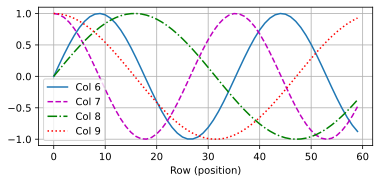

In [4]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

In [5]:
for i in range(8):
    print(f'{i} in binary is {i:>03b}')

0 in binary is 000
1 in binary is 001
2 in binary is 010
3 in binary is 011
4 in binary is 100
5 in binary is 101
6 in binary is 110
7 in binary is 111


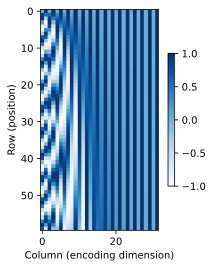

In [6]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
d2l.show_heatmaps(P, xlabel='Column (encoding dimension)', ylabel='Row (position)', figsize=(3.5, 4), cmap='Blues')

=============================================== The Transformer Architecture ============================================

In [7]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

Unlike earlier self-attention models that still rely on RNNs for input representations, the Transformer model is solely based on attention mechanisms without any convolutional or recurrent layer 

![The Transformer Architecture](./Images/The%20Transformer%20archiecture.png)

#### Transformer Architecture Overview

##### 1. Encoder Architecture
- The Transformer **encoder** is a stack of **N identical layers**
- Each encoder layer contains **two sublayers**:
  1. **Multi-head self-attention**
  2. **Position-wise feed-forward network (FFN)**

##### Encoder Self-Attention
- Queries, keys, and values all come from the **previous encoder layer output**
- Each token can attend to **all tokens in the input sequence**

##### Residual Connections + Layer Normalization
- Each sublayer is wrapped with a **residual connection**
- Followed immediately by **layer normalization**
- Requires input and output dimensions to match: $\text{input} \in \mathbb{R}^d \Rightarrow \text{output} \in \mathbb{R}^d$
- Helps with:
  - Stable training
  - Gradient flow
  - Deeper networks

##### Encoder Output
- Produces a **$d$ -dimensional vector** for **each position** in the input sequence
- Output shape: (batch_size, sequence_length, d)

##### 2.Decoder Architecture
- The Transformer **decoder** is also a stack of **N identical layers**
- Each decoder layer has **three sublayers**:
1. **Masked multi-head self-attention**
2. **Encoder–decoder (cross) attention**
3. **Position-wise feed-forward network**

##### Masked Self-Attention (Decoder)
- Queries, keys, and values come from the **previous decoder layer**
- Each position can attend **only to itself and earlier positions**
- Future positions are **masked**
- Ensures **autoregressive property**:
- Prediction at time step $t$ depends only on outputs $\le t$

##### Encoder–Decoder Attention
- Queries come from the **decoder**
- Keys and values come from the **encoder outputs**
- Allows the decoder to:
  - Focus on relevant parts of the input sequence
  - Align output tokens with input tokens

##### Residual Connections + Layer Normalization
- Applied around **all three sublayers**
- Same design as the encoder (ResNet-style)

##### Core Design Principles
- **Self-attention** captures global dependencies efficiently
- **Multi-head attention** enables learning from multiple representation subspaces
- **Positional encoding** injects sequence order information
- **Residual connections + layer norm** stabilize deep stacking
- Encoder builds **contextual representations**
- Decoder generates outputs **autoregressively**, guided by encoder context

##### High-Level Data Flow
Input → Embedding + Positional Encoding
→ Encoder (N layers)
→ Decoder (N layers, masked)
→ Linear + Softmax
→ Output tokens

##### One-Sentence Summary
The Transformer uses stacked self-attention and feed-forward layers with residual connections and normalization, where the encoder builds contextual representations of the input and the decoder generates outputs autoregressively while attending to encoder outputs.

In [1]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
class PositionWiseFFN(nn.Module):  #@save
    """The positionwise feed-forward network."""
    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [3]:
ffn = PositionWiseFFN(4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

/workspaces/pytorch-basics/.venv310/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


tensor([[ 0.2426, -0.7263,  0.4339,  0.3381,  0.0359, -0.1578,  0.4313,  0.2861],
        [ 0.2426, -0.7263,  0.4339,  0.3381,  0.0359, -0.1578,  0.4313,  0.2861],
        [ 0.2426, -0.7263,  0.4339,  0.3381,  0.0359, -0.1578,  0.4313,  0.2861]],
       grad_fn=<SelectBackward0>)

In [4]:
ln = nn.LayerNorm(2)
bn = nn.LazyBatchNorm1d()
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# Compute mean and variance from X in the training mode
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [5]:
class AddNorm(nn.Module):  #@save
    """The residual connection followed by layer normalization."""
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [ ]:
add_norm = AddNorm(4, 0.5)
shape = (2, 3, 4)
d2l.check_shape(add_norm(torch.ones(shape), torch.ones(shape)), shape)

In [6]:
class TransformerEncoderBlock(nn.Module):  #@save
    """The Transformer encoder block."""
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout,
                 use_bias=False):
        super().__init__()
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(num_hiddens, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [ ]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = TransformerEncoderBlock(24, 48, 8, 0.5)
encoder_blk.eval()
d2l.check_shape(encoder_blk(X, valid_lens), X.shape)

In [ ]:
class TransformerEncoder(d2l.Encoder):  #@save
    """The Transformer encoder."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, use_bias=False):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerEncoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias))

    def forward(self, X, valid_lens):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

In [ ]:
encoder = TransformerEncoder(200, 24, 48, 8, 2, 0.5)
d2l.check_shape(encoder(torch.ones((2, 100), dtype=torch.long), valid_lens),(2, 100, 24))

In [ ]:
class TransformerDecoderBlock(nn.Module):
    # The i-th block in the Transformer decoder
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.attention2 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(num_hiddens, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so state[2][self.i] is None as initialized. When
        # decoding any output sequence token by token during prediction,
        # state[2][self.i] contains representations of the decoded output at
        # the i-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), dim=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of dec_valid_lens: (batch_size, num_steps), where every
            # row is [1, 2, ..., num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of enc_outputs:
        # (batch_size, num_steps, num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [ ]:
decoder_blk = TransformerDecoderBlock(24, 48, 8, 0.5, 0)
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
d2l.check_shape(decoder_blk(X, state)[0], X.shape)

In [ ]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerDecoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.LazyLinear(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.num_blks]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

In [ ]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

In [ ]:
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), d2l.try_gpu(), data.num_steps, True)
enc_attention_weights = torch.cat(model.encoder.attention_weights, 0)
shape = (num_blks, num_heads, -1, data.num_steps)
enc_attention_weights = enc_attention_weights.reshape(shape)
d2l.check_shape(enc_attention_weights,
                (num_blks, num_heads, data.num_steps, data.num_steps))

In [ ]:
d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

In [ ]:
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weights
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
shape = (-1, 2, num_blks, num_heads, data.num_steps)
dec_attention_weights = dec_attention_weights_filled.reshape(shape)
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)

d2l.check_shape(dec_self_attention_weights,
                (num_blks, num_heads, data.num_steps, data.num_steps))
d2l.check_shape(dec_inter_attention_weights,
                (num_blks, num_heads, data.num_steps, data.num_steps))

In [ ]:
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

In [ ]:
d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))